1. Are interpretable Kickstarter success prediction models equally accurate across categories? And furthermore, are models trained within specific categories more predictive within their category than models that are trained generally?
- Train models on the whole dataset
- Predict and analyze within each category
- Train models on data within each category
- Predict and analyze within each category
- Compare and contrast predictive performance, and also feature importances. What factors matter more within each category? Are there differences?


General analysis
- Average goal amounts by category.
- Success rate differences by country.
- Correlation analysis
- Using trees and nonlinear models + feature importances
<!-- 
2. Which factors matter most at launch for predicting campaign success?
- goal, duration, country, category, has_video, staff_pick, etc -->

# LOAD

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import re
import pandas as pd
from utils import load_data

In [49]:
kickstarter: pd.DataFrame = load_data(verbose = True)
kickstarter_toy = load_data(partial = True)

83 FILES LOADED | TOTAL ROWS: 262892


# PREPROCESSING

0. [Feature Descriptions](#feature-descriptions)
1. [Data Integrity Analysis]



1. [Data Filtering, Leakage Prevention, and Feature Relevance Assessment](#data-filtering-leakage-prevention-and-feature-relevance-assessment)
2. Descriptive Statistics
3. Duplication analysis
4. Missingness analysis
5. Feature engineering
6. Feature selection and dimensionality reduction

### Feature Descriptions

In [3]:
kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262892 entries, 0 to 262891
Data columns (total 42 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   backers_count                       262892 non-null  int64  
 1   blurb                               262811 non-null  object 
 2   category                            262892 non-null  object 
 3   converted_pledged_amount            245625 non-null  float64
 4   country                             262892 non-null  object 
 5   country_displayable_name            262892 non-null  object 
 6   created_at                          262892 non-null  int64  
 7   creator                             262892 non-null  object 
 8   currency                            262892 non-null  object 
 9   currency_symbol                     262892 non-null  object 
 10  currency_trailing_code              262892 non-null  bool   
 11  current_currency          

Grouped generally by meaning:

**Identifiers & Text**
- `id`: internal project ID
- `name`: project title
- `blurb`: short description

**URLs & Media**
- `slug`: URL slug of the project
- `source_url`: The category url
- `urls`: dictionary with urls pertaining to that project. The project front page, the rewards page, etc.
- `photo`: dictionary with urls to the photos used in the banner, thumbnail etc.  
- `video`: dictionary with video information  

**Creator & Project Profile Information**
- `creator`: dictionary with creator information  
  - name, is_registered, is_email_verified, chosen_currency, is_superbacker, has_admin_message_badge, ppo_has_action, backing_action_count, avatar (image urls)
- `profile`: dictionary with some redundant project page text information, and some page styling information
- `category`: dictionary with categorical information about the campaign
  - name, analytics_name, slug, position, parent_name, and some page information  

**Geographic Details**
- `country`: 2 letter country abbreviation  
- `country_displayable_name`: human-readable country name  
- `location`: dictionary with location information  
  - 'id', 'name', 'slug', 'short_name', 'displayable_name', 'localized_name', 'country', 'state', 'type', 'is_root', 'expanded_country', 'urls'  


**Goals & Currency**
- `goal`: funding goal in the project's currency  
- `currency`: original currency code  
- `currency_symbol`: the display symbol for currency  
- `currency_trailing_code`: whether symbol / code trails the number (BOOL)  

**Exchange Rates**
- `fx_rate`: snapshot FX rate (original currency to USD)  
- `static_usd_rate`: platform's "static" USD rate  
- `usd_exchange_rate`: FX used for pledged -> USD at update time  
- `usd_type`: how USD conversion was computed  

**Funding & Performance**
- `backers_count`: number of backers (count)  
- `pledged`: amount pledged in original currency  
- `converted_pledged_amount`: pledged converted to USD  
- `usd_pledged`: pledged in USD  
- `percent_funded`: 100 * pledged / goal  

**Timestamps**
- `created_at`: date the project was first drafted  
- `launched_at`: project's actual launch date (went live)  
- `deadline`: scheduled ending time  
- `state_changed_at`: date the projecct's status was last changed  

**Launch & Visibility**
- `is_launched`: whether the project was launched  
- `prelaunch_activated`: whether a "coming soon" page was used  
- `staff_pick`: a staff-curated badge  
- `spotlight`: specially highlighted page  

**Interaction & Moderation**
- `disable_communication`: whether comments / updates are disabled  
- `is_starrable`: whether users can "star" it  
- `is_liked`, `is_disliked`: viewer specific liked or disliked (all False here)  
- `is_in_post_campaign_pledging_phase`: whether the campaign finished and is in its pledge fulfilling phase (only for successful)  

**Target**
- `state`: project status string. Can be:  
  - successful - reached goal by deadline (positive class)  
  - failed - did not reach goal by deadline (negative class)  
  - submitted - submitted for review by Kickstarter staff but not yet live  
  - live - project is currently active and accepting pledges  
  - canceled - creator canceled before deadline  
  - suspended - Kickstarter suspended (ToS)  


### Data Integrity Analysis

#### Duplication Analysis

From a base `.duplicated().sum()` count, we observe very few "true duplicated rows":

In [4]:
print("True duplicated rows: ", kickstarter.duplicated().sum())

True duplicated rows:  12


However, examining duplication only considering unique `id`:

In [5]:
print("Duplicate ids: ", kickstarter['id'].duplicated().sum())

Duplicate ids:  57362


It's clear true duplication is not the full picture.
- We have only 12 truly duplicate rows
- But we have 57362 duplicate ids

Something doesn't add up. Its likely that this scrape contains multiple snapshots per project. Since we do not have a column which indicates "most updated" row, we must make a few judgement calls.

First, we want to analyze which columns are likely the "update" column that is causing our true duplication to be so low:

In [6]:
id_column_pair_duplication = []
for column in kickstarter.columns:
    if column != 'id':
        duplication_count = kickstarter[['id', column]].duplicated().sum()
        id_column_pair_duplication.append({
            'id_feature_pair': column,
            'duplication_count': duplication_count
        })
id_column_pair_duplication = pd.DataFrame(id_column_pair_duplication)
display(id_column_pair_duplication.sort_values(by = 'duplication_count'))

,id_feature_pair,duplication_count
7,creator,14
30,source_url,1747
22,location,43834
14,fx_rate,48054
3,converted_pledged_amount,56379
37,usd_exchange_rate,56439
40,video,56455
38,usd_pledged,56946
26,pledged,56960
24,percent_funded,56960


Overwhelmingly, it seems to be the fault of the `creator` feature.
- At some time during a campaign's lifetime, the creator might be actively changing their information, their username, profile picture, whether they are verified, etc.
- The minute changes were then counted as separate in the scrape.

Unfortunately, this does not narrow down how best to choose amongst the duplicate `id` rows.
- Within `creator` there is no timestamp information for when this feature was changed.

Trying to narrow down how best to choose amongst the other features also has varying issues:
- Most features don't have recency built in. For example: though `location` with `id` has substatially lower duplicates, we cannot differentiate which to keep based on location, since we do not know the true final location.
- Most features will not eliminate many duplicates. For example: picking by most backers seems like a reasonable judgement, but this will maximally only eliminate a couple hundred duplicates.

For these reasons, we will make the following judgement calls to address duplication:
1. Eliminate true duplicates (easily safe)
2. Narrow down duplicates based on most backers (will eliminate a couple hundred)
3. Drop the rest of the duplicates by `id`

The final drop can be reasoned with the following - because the duplicates are already so similar in the most important factors beside creator, keeping duplicates at random with a final drop is as reasonable as we can afford.

In [7]:
def apply_deduplication_steps(kickstarter) -> pd.DataFrame:
    kick_nodup = kickstarter.copy()
    print(f"Number of rows before deduplication: {kick_nodup.__len__()}")
    # Eliminate true duplicates
    kick_nodup = kick_nodup.drop_duplicates()

    # Narrow down by most backers (built in recency)
    max_per_id = kick_nodup.groupby("id")["backers_count"].transform("max") # Group rows by id, get backers_count
                                                                            # transform("max") gives us a series 1:1 with original except filling each row with the group max
    kick_nodup = kick_nodup[kick_nodup["backers_count"] == max_per_id]

    # Drop the rest of the duplicates by `id`
    kick_nodup = kick_nodup.drop_duplicates(subset=['id']).reset_index()
    print(f"Number of rows after applying deduplication steps: {kick_nodup.__len__()}")
    
    return kick_nodup
kick_nodup = apply_deduplication_steps(kickstarter)

Number of rows before deduplication: 262892
Number of rows after applying deduplication steps: 205530


#### Missingness Analysis

First examining the missingness of the set after deduplication

PERCENTAGE MISSING
blurb                                  0.018489
usd_type                               0.030652
location                               0.121637
converted_pledged_amount               3.818421
usd_pledged                            3.818421
usd_exchange_rate                      3.818421
video                                 35.736389
is_in_post_campaign_pledging_phase    73.960006
dtype: float64


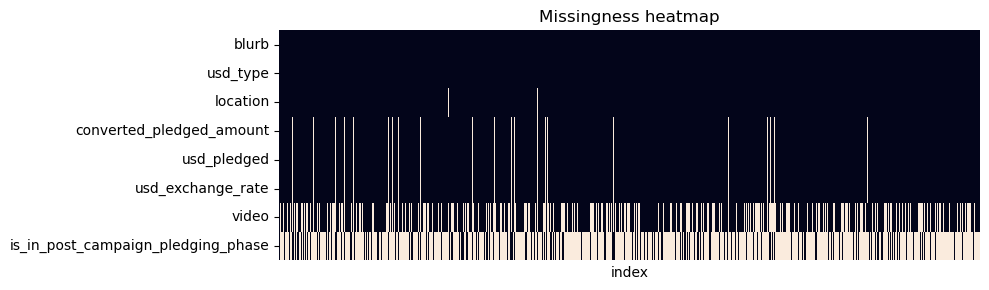

In [8]:
nulls = kick_nodup.isnull().sum(axis = 0)
nulls = nulls[nulls > 0].sort_values(ascending=True) # Filtering for columns that actually have at least 1 missing value

print("PERCENTAGE MISSING")
print(nulls / kick_nodup.__len__() * 100)

mask = kick_nodup.isnull()
mask = mask[nulls.index]
mat = mask.T

plt.figure(figsize = (10, 3))
ax = sns.heatmap(
    mat.astype(int),
    cbar = False,
    linewidths = 0,
    xticklabels = False
)
ax.set_xlabel("index")
ax.set_title("Missingness heatmap")
plt.tight_layout()
plt.show()

In [9]:
kickstarter.groupby(by = 'currency')['usd_exchange_rate'].mean()

currency
AUD    0.710124
CAD    0.761515
CHF    1.091357
DKK    0.150593
EUR    1.114854
GBP    1.345056
HKD    0.128127
JPY    0.007312
MXN    0.051901
NOK    0.114292
NZD    0.667173
PLN    0.257319
SEK    0.109056
SGD    0.744796
USD    1.000000
Name: usd_exchange_rate, dtype: float64

We have just only a few missing values for `blurb`, `usd_type` and `location`
- All three only have a couple hundredths of a percent missing.

We have slighly higher missingness in `converted_pledged_amount`, `usd_pledged` and `usd_exchange_rate`:
- All three have exactly the same missingness, at 6.57% missingness
- Furthermore, they seem to be conjointly missing, meaning if one is missing, the other two are also always missing

Lastly we have highest missinging in `video` and `is_in_post_campaign_pledging_phase`:
- `video` having 27.93% missingness and `is_in_post_campaign_pledging_phase` having 57.82% missingness.

---

**Examining features closer to inform imputation:**

For `blurb`:
- Since `blurb` is unique to each particular campaign, it is inappropriate to impute this with anything we can assume from other data points
    - We will assume the blurb will be similar in content to the title, and impute by project name.

In [39]:
def impute_blurb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['blurb'] = df['blurb'].fillna(df['name'])
    return df

For `usd_type`:

In [10]:
# Examining usd_type
usd_type_mode = kickstarter["usd_type"].mode()[0]
print(
    f"Percentage of 'usd_type' that is {usd_type_mode}: {(
        (kickstarter["usd_type"] == usd_type_mode).sum()
        / kickstarter.__len__()
        * 100
    )}%"
)

Percentage of 'usd_type' that is domestic: 99.9269662066552%


Reasonable to impute by mode, given that the dataset is overwhelming one mode.

In [40]:
def impute_usd_type(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["usd_type"] = df["usd_type"].fillna(df["usd_type"].mode()[0])
    return df

---

For `location`

In [11]:
# Examining location
def parse_json_feature(raw):
    return json.loads(raw)

parse_json_feature(kickstarter['location'][0])

{'id': 44418,
 'name': 'London',
 'slug': 'london-gb',
 'short_name': 'London, UK',
 'displayable_name': 'London, UK',
 'localized_name': 'London',
 'country': 'GB',
 'state': 'England',
 'type': 'Town',
 'is_root': False,
 'expanded_country': 'United Kingdom',
 'urls': {'web': {'discover': 'https://www.kickstarter.com/discover/places/london-gb',
   'location': 'https://www.kickstarter.com/locations/london-gb'},
  'api': {'nearby_projects': 'https://api.kickstarter.com/v1/discover?signature=1757604986.29d3e3985af91871c322a99e8bdbb47f0d7ec263&woe_id=44418'}}}

We can see several potentially useful data fields within `location`. Namely:
- `name`, which seems to be city name.
- `state`, which seems to be state name.
- `type`, which seems to indicate the type of location.

In [12]:
# Examining distributions for location

locations_not_null = kickstarter[kickstarter['location'].notnull()]['location'].apply(parse_json_feature)
location_cols = locations_not_null.apply(
    lambda d: pd.Series({
        'loc_name': d.get('name'),
        'loc_state': d.get('state'),
        'loc_type': d.get('type'),
    })
)
location_cols.describe()


,loc_name,loc_state,loc_type
count,262495,262423,262495
unique,14130,1221,9
top,London,CA,Town
freq,11216,28529,244120


Location information seems to follow a heavy right skewed distribution. For type in particular, town seems to be overwhelmingly common. For state and name, the skew is not sharp enough to assume any particularly overwhelmingly common singular value.
- For all three: we cannot impute by most common and expect a probable correctness of our fit.

We will impute by mode of the missing value grouped by country. So, if a city name is missing from the US, for example, the state, city and town would be imputed as CA, Los Angeles, Town.

Lastly, we will discard `location` column, as all relevant information has already been extracted from it.

In [ ]:
# "Impute" + engineering. We are engineering new features then imputing those features
def impute_location(df: pd.DataFrame) -> pd.DataFrame:
    def parse_json_feature(raw):
        return json.loads(raw)
    locations_not_null = df[df['location'].notnull()]['location'].apply(parse_json_feature)
    location_cols = locations_not_null.apply(
        lambda d: pd.Series({
            'loc_name': d.get('name'),
            'loc_state': d.get('state'),
            'loc_type': d.get('type'),
        })
    )

    df = df.join(location_cols, how='left')

    mode_loc_name_by_country = (
        df.loc[df["loc_name"].notnull()]
        .groupby("country")["loc_name"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    df["loc_name"] = df["loc_name"].fillna(df["country"].map(mode_loc_name_by_country))

    mode_loc_state_by_country = (
        df.loc[df["loc_state"].notnull()]
        .groupby("country")["loc_state"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    df["loc_state"] = df["loc_state"].fillna(df["country"].map(mode_loc_state_by_country))

    mode_loc_type_by_country = (
        df.loc[df["loc_type"].notnull()]
        .groupby("country")["loc_type"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    df["loc_type"] = df["loc_type"].fillna(df["country"].map(mode_loc_type_by_country))

    df = df.drop(columns = ['location'])
    return df

---

For `usd_pledged`, `converted_pledged_amount` and `usd_exchange_rate`

- $\text{usd\_pledged} = \text{pledged} \times \text{static\_usd\_rate}$. 
    - Since neither of those are missing when `usd_pledged` is missing, we will simply fill in the missing portion by formula.
- $\text{converted\_pledged\_amount} = \lfloor \text{pledged} \times \text{usd\_exchange\_rate} \rfloor$.
    - We will use the non missing `currency` featuer to impute missing `usd_exchange_rate`, then use that to impute the missing `converted_pledged_amount` by formula.
    - Because `usd_exchange_rate` for each currency changes for each observation (the exchange rate changes over time), we will impute this based on the mean of the currency's exchange rate.

In [57]:
# kickstarter_toy.isnull().sum()
kickstarter_toy['usd_pledged'] = kickstarter_toy['usd_pledged'].fillna(kickstarter_toy['pledged'] * kickstarter_toy['static_usd_rate'])

    # Impute usd_exchange_rate
mean_usd_exchange_rate_by_currency = kickstarter_toy.groupby(by = 'currency')['usd_exchange_rate'].mean()
kickstarter_toy['usd_exchange_rate'].fillna(kickstarter_toy['currency'].map(mean_usd_exchange_rate_by_currency))

    # Impute converted_pledged_amount
kickstarter_toy['converted_pledged_amount'] = kickstarter_toy['converted_pledged_amount'].fillna(kickstarter_toy['pledged'] * kickstarter_toy['usd_exchange_rate'])
kickstarter_toy.isnull().sum()


backers_count                            0
blurb                                    0
category                                 0
converted_pledged_amount               181
country                                  0
country_displayable_name                 0
created_at                               0
creator                                  0
currency                                 0
currency_symbol                          0
currency_trailing_code                   0
current_currency                         0
deadline                                 0
disable_communication                    0
fx_rate                                  0
goal                                     0
id                                       0
is_disliked                              0
is_in_post_campaign_pledging_phase    2032
is_launched                              0
is_liked                                 0
is_starrable                             0
launched_at                              0
location   

In [59]:
def impute_money_features(df: pd.DataFrame) -> pd.DataFrame:
    # Impute usd_pledged
    df['usd_pledged'] = df['usd_pledged'].fillna(df['pledged'] * df['static_usd_rate'])

    # Impute usd_exchange_rate
    mean_usd_exchange_rate_by_currency = df.groupby(by = 'currency')['usd_exchange_rate'].mean()
    df['usd_exchange_rate'] = df['usd_exchange_rate'].fillna(df['currency'].map(mean_usd_exchange_rate_by_currency))

    # Impute converted_pledged_amount
    df['converted_pledged_amount'] = df['converted_pledged_amount'].fillna(df['pledged'] * df['usd_exchange_rate'])
    return df

---

For `video`
- No imputation, instead converting `video` into an indicator variable later during feature engineering. We don't intend to deal with video data, but since we have sufficient missingness, we can use the missingness itself as a predictor.

In [45]:
# This is closer to transformation than imputation, but for our purpose, it is transformation in service to imputate
def impute_video(df: pd.DataFrame) -> pd.DataFrame:
    df['has_video'] = df['video'].notnull()
    df = df.drop(columns = ['video'])
    return df

---
For `is_in_post_campaign_pledging_phase`
- An indicator variable for whether a project is already successful and currently fulfilling pledges. This feature has high missingness at nearly 74% missing.
    - Both for data leakage prevention and for the fact of high missingness, the column is simply dropped.

In [47]:
def impute_is_in_post_campaign_pledging_phase(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns = ['is_in_post_campaign_pledging_phase'])
    return df

---

Applying missingness strategies:

In [100]:
def perform_missingness_handling(df: pd.DataFrame) -> pd.DataFrame:
    df = impute_blurb(df)
    df = impute_usd_type(df)
    df = impute_location(df)
    df = impute_money_features(df)
    df = impute_video(df)
    df = impute_is_in_post_campaign_pledging_phase(df)
    return df
kick_clean = perform_missingness_handling(kickstarter)

In [62]:
kick_clean.isnull().sum()

backers_count               0
blurb                       0
category                    0
converted_pledged_amount    0
country                     0
country_displayable_name    0
created_at                  0
creator                     0
currency                    0
currency_symbol             0
currency_trailing_code      0
current_currency            0
deadline                    0
disable_communication       0
fx_rate                     0
goal                        0
id                          0
is_disliked                 0
is_launched                 0
is_liked                    0
is_starrable                0
launched_at                 0
name                        0
percent_funded              0
photo                       0
pledged                     0
prelaunch_activated         0
profile                     0
slug                        0
source_url                  0
spotlight                   0
staff_pick                  0
state                       0
state_chan

### Data Filtering, Leakage Prevention, and Feature Relevance Assessment

**Filtering for final outcome**

Because we are interested in supervised modeling, we will only keep projects with finalized outcomes. Meaning projects either **successful**, or **failed** final `state`.

In [63]:
# Keep only final outcome states
def keep_only_final_outcome_states(df: pd.DataFrame):
    df = df[df['state'].isin(['successful', 'failed'])].copy()
    return df

**Leakage Prevention**

Data leakage features are those that contain information unavailable at the time of prediction (e.g., after campaign launch or after campaign ends).

| Column                                               | Why it leaks                                              |
| ---------------------------------------------------- | --------------------------------------------------------- |
| `backers_count`                                      | Number of backers is directly correlated to the pledged amount.                        |
| `pledged`, `usd_pledged`, `converted_pledged_amount` | Contain the actual outcome.                               |
| `percent_funded`                                     | Directly derived from `pledged / goal`.                   |
| `usd_exchange_rate`                                  | Calculated after pledges are received.                    |
| `state_changed_at`                                   | Timestamp of final outcome.                               |
| `spotlight`                                          | Spotlight is always true for successfully funded projects (all funded projects gain access to spotlighting tools).                       |
| `is_in_post_campaign_pledging_phase`                 | Only exists post-outcome.                                 |

In [98]:
def drop_leakage_columns(df: pd.DataFrame) -> pd.DataFrame:
    leakage_columns = [
        "backers_count",
        "pledged",
        "usd_pledged",
        "converted_pledged_amount",
        "percent_funded",
        "usd_exchange_rate",
        "state_changed_at",
        "spotlight",
        # "is_in_post_campaign_pledging_phase",
    ]

    df = df.drop(columns=leakage_columns).copy()
    return df

**Irrelevant or Redundant Features**

Features that do not describe the campaign meaningfully or are purely metadata / UI-oriented.

| Column                                                          | Reason                                                                              |
| --------------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| `id`, `slug`, `source_url`, `urls`                              | Internal or web-identifiers.                                                        |
| `currency_symbol`, `currency_trailing_code`, `current_currency` | Formatting/UI attributes.                                                           |
| `is_liked`, `is_disliked`, `is_starrable`                       | Viewer-specific or static fields. These are all either false or true for this scrape.                                                |
| `country_displayable_name`                                      | Redundant with `country`.                                                           |


In [65]:
def drop_irrelevant_columns(df: pd.DataFrame) -> pd.DataFrame:
    irrelevant_columns = [
        "id",
        "slug",
        "source_url",
        "urls",
        "currency_symbol",
        "currency_trailing_code",
        "current_currency",
        "is_liked",
        "is_disliked",
        "is_starrable",
        "country_displayable_name",
    ]

    df = df.drop(columns = irrelevant_columns).copy()
    return df

**Complex nested JSON feature relevance analysis**

Many features are nested dictionaries of further features. Most of the nested dictionary contains information that may not be used, but further examination is necessary to determine exactly what information to retain. `photo`, `creator`, and `profile` in particular do not seem to hold relevant information, but further analysis is needed to be sure.

For `photo`
- Our analysis will not directly deal with complex image data. This column has no direct missingness, but since the object is nested, we need to perform analysis on whether the object is truly not missing for all rows. This will inform whether an indicator variable should be considered, or the column should simply be dropped.

In [66]:
# Checking missingness of image (per scrape observation)
num_photo_missing = kick_clean['photo'].isnull().sum()
print(f"Number of missing videos = {num_photo_missing} \
      Percentage: {num_photo_missing / kick_clean.__len__() * 100:.2f}%")

# Checking if every campaign has an image present in their photo json object
photos = kick_clean["photo"].apply(json.loads)
some_missing_full_image = photos.apply(lambda x: pd.isnull(x.get("full"))).any()
print("Photo status:")
if some_missing_full_image:
    print("\tPhoto missing for some campaign(s)! Consider indicator variable")
else:
    print("\tEvery campaign has a photo! Consider dropping photo")

Number of missing videos = 0       Percentage: 0.00%
Photo status:
	Every campaign has a photo! Dropping photo


Since every single campaign in our list has an image, an indicator variable would not be informative.

In [67]:
def drop_photo(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns = ['photo']).copy()
    return df

---

For `creator`:
- This variable is rather difficult to parse, since there are so many extra inner quotes present that are unescaped.

In [95]:
def parse_kickstarter_creator(raw):
    raw = raw.replace('\t', '\\t').replace('\n', '\\n').replace('\r', '\\r')
    # fix name: remove extra inner quotes in the name value
    key_start = '"name":"'
    i = raw.find(key_start)
    if i != -1:
        name_start = i + len(key_start)
        j = raw.find('","', name_start)  # end of the name string
        if j != -1:
            name_val = raw[name_start:j]
            name_fixed = name_val.replace('"', '')  # strip stray inner quotes
            raw = raw[:name_start] + name_fixed + raw[j:]

    # I can catch most of the problems with the simple above fix, but there are a few that are
    # simply not worth the trouble to fully catch
    try:
        return json.loads(raw)
    except Exception:
        print("EXCEPTION: ", raw)
        return np.nan

creators = kick_clean['creator'].apply(parse_kickstarter_creator)

total_not_null = 0
for creator in creators:
    if type(creator) is float:
        continue
    if pd.notnull(creator['is_email_verified']) or pd.notnull(creator['is_registered']) or pd.notnull(creator['is_superbacker']):
        total_not_null += 1
print("Total not null: ", total_not_null)

EXCEPTION:  {"id":860665384,"name":"//DoloMcCombKimberlyLesikScottStafford\\\","slug":"cathedralcollective","is_registered":null,"is_email_verified":null,"chosen_currency":null,"is_superbacker":null,"has_admin_message_badge":false,"ppo_has_action":false,"backing_action_count":0,"avatar":{"thumb":"https://i.kickstarter.com/assets/010/849/136/eb10895768e7303de07eeccbfad69581_original.png?anim=false&fit=cover&height=40&origin=ugc&q=92&v=1461716176&width=40&sig=751vXIb%2FFwhKjKv7vIvtx5bgS7HL5Pf%2B1gpiihWiyo0%3D","small":"https://i.kickstarter.com/assets/010/849/136/eb10895768e7303de07eeccbfad69581_original.png?anim=false&fit=cover&height=80&origin=ugc&q=92&v=1461716176&width=80&sig=14iCZVvR3QuSni9vqP7dBpKcYE4rXZYVmTooPU6nk6M%3D","medium":"https://i.kickstarter.com/assets/010/849/136/eb10895768e7303de07eeccbfad69581_original.png?anim=false&fit=cover&height=160&origin=ugc&q=92&v=1461716176&width=160&sig=JbMG%2BdjEr5aceHdY3d9hzdl08DcPvEifDZvbuy2fYy8%3D"},"urls":{"web":{"user":"https://www.kic

- This variable contains some various information like name, avatar, whether they are registered or email verified, etc.
- Unfortunately, it seems that boolean information, like whether they are registered or not, is fully missing from this variable, so there is nothing useful for us to extract.
- We may consider further analysis with this variable later (for example, analysis on whether creator's have more success if they have had experience with other kickstarter projects), but for now we deem it irrelevant.

In [96]:
def drop_creator(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns = ['creator']).copy()
    return df

---

For `profile`

In [93]:
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
kick_clean['profile'].tail(20).apply(parse_json_feature).values

array([{'id': 963338, 'project_id': 963338, 'state': 'inactive', 'state_changed_at': 1425915853, 'name': None, 'blurb': None, 'background_color': None, 'text_color': None, 'link_background_color': None, 'link_text_color': None, 'link_text': None, 'link_url': None, 'show_feature_image': False, 'background_image_opacity': 0.8, 'should_show_feature_image_section': True, 'feature_image_attributes': {'image_urls': {'default': 'https://i.kickstarter.com/assets/011/680/204/7108ed19384fbb551aaf154e0f192991_original.png?anim=false&fit=cover&gravity=auto&height=873&origin=ugc&q=92&v=1463686697&width=1552&sig=nt4CfhTUisWv9obcTWEw%2BU6W9t5ix%2FOYxI4XgLsH%2BsQ%3D', 'baseball_card': 'https://i.kickstarter.com/assets/011/680/204/7108ed19384fbb551aaf154e0f192991_original.png?anim=false&fit=cover&gravity=auto&height=315&origin=ugc&q=92&v=1463686697&width=560&sig=d7eDV6eVyfalmDkbUNGO7zm7FKkLCEDlsru8T0hCEv4%3D'}}},
       {'id': 1557981, 'project_id': 1557981, 'state': 'inactive', 'state_changed_at': 142


- Contains redundant text information (like title and blurb), and upon further examination, the extra page styling information is fully missing from this variable. Because of this, this is deemed not useful to extract and redundant.

In [68]:
def drop_profile(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns = ['profile']).copy()
    return df

---

Applying data filtering for leakage prevention and feature relevance

In [101]:
def apply_data_filtering_steps(df: pd.DataFrame) -> pd.DataFrame:
    df = keep_only_final_outcome_states(df)
    df = drop_leakage_columns(df)
    df = drop_irrelevant_columns(df)
    df = drop_photo(df)
    df = drop_creator(df)
    df = drop_profile(df)
    return df
kick_clean = apply_data_filtering_steps(kick_clean)

In [103]:
kick_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228211 entries, 0 to 262890
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   blurb                  228211 non-null  object 
 1   category               228211 non-null  object 
 2   country                228211 non-null  object 
 3   created_at             228211 non-null  int64  
 4   currency               228211 non-null  object 
 5   deadline               228211 non-null  int64  
 6   disable_communication  228211 non-null  bool   
 7   fx_rate                228211 non-null  float64
 8   goal                   228211 non-null  float64
 9   is_launched            228211 non-null  bool   
 10  launched_at            228211 non-null  int64  
 11  name                   228211 non-null  object 
 12  prelaunch_activated    228211 non-null  bool   
 13  staff_pick             228211 non-null  bool   
 14  state                  228211 non-null  o

### Feature Engineering

Here we will address further features that may be relevant, but are currently unusuable in our future modeling. We need to:
- Parse the remaining JSON features and extract relevant info
- Convert text data into usable forms


For `category`:
- `category` is be a relevant feature, but it is, like many other features, in string literal JSON dictionary form and is unsuable in the current state. We will transform this variable, and engineering features from it that may be useful to us.

### Descriptive Statistics

Some descriptive statistics, separated by variable type

In [105]:
# kickstarter.describe()
kick_clean.describe()

,created_at,deadline,fx_rate,goal,launched_at,static_usd_rate
count,2.282110e+05,2.282110e+05,228211.000000,2.282110e+05,2.282110e+05,228211.000000
mean,1.577898e+09,1.585630e+09,0.984568,5.536750e+04,1.582766e+09,0.980131
std,1.310069e+08,1.314081e+08,0.270366,3.136087e+06,1.314160e+08,0.266180
min,1.240366e+09,1.242468e+09,0.006782,1.000000e-02,1.240674e+09,0.006209
25%,1.459899e+09,1.466835e+09,1.000000,1.415000e+03,1.464031e+09,1.000000
50%,1.587402e+09,1.596140e+09,1.000000,5.000000e+03,1.593036e+09,1.000000
75%,1.709572e+09,1.717887e+09,1.000000,1.360000e+04,1.715099e+09,1.000000
max,1.756966e+09,1.757567e+09,1.353290,1.000000e+09,1.757149e+09,1.716408


In [106]:
kick_clean.select_dtypes('object').describe()

,blurb,category,country,currency,name,state,usd_type,loc_name,loc_state,loc_type
count,228211,228211,228211,228211,228211,228211,228211,228211,228211,228211
unique,183807,171,25,15,185407,2,1,13415,1189,9
top,"A high-quality Figurines, STL file, 3D printab...","{""id"":34,""name"":""Tabletop Games"",""analytics_na...",US,USD,A Midsummer Night's Dream,successful,domestic,London,CA,Town
freq,55,7086,144928,144937,9,150630,228211,9819,25302,211875


In [107]:
kick_clean.select_dtypes('bool').describe()

,disable_communication,is_launched,prelaunch_activated,staff_pick,has_video
count,228211,228211,228211,228211,228211
unique,2,1,2,2,2
top,False,True,False,False,True
freq,228209,228211,161534,189373,153473


### Feature Engineering

# MODELING

1. Naive baseline (majority class model)
- Predict everything as the majority class

In [122]:
majority_class = kick_clean['state'].value_counts().sort_values(ascending = False).keys()[0]
predictions = np.full_like(kick_clean['state'], majority_class)

accuracy = (predictions == kick_clean['state']).mean()

print(f"Majority class baseline model accuracy: {accuracy * 100:.2f}%")

Majority class baseline model accuracy: 66.00%
